In [1]:
# read raw csv
import glob
import pandas as pd
# read the latest file in the csv folder
# file is obtained by Twitter Media Downloader
# https://memo.furyutei.work/entry/20160723/1469282864
dir = sorted(glob.glob('./CSV/*/'))[-1]
file = glob.glob(dir+'*dryrun.csv')[0]
c_d = pd.read_csv(file,
                      parse_dates=["Tweet date"],
                      skiprows=[0,1,2,3])
c_d

/home/eggplant/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,Tweet date,Action date,Display name,Username,Tweet URL,Media type,Media URL,Saved filename,Remarks,Tweet content,Replies,Retweets,Likes
0,2020-02-21 11:24:13,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12306...,Image,https://pbs.twimg.com/media/ERRAkIlUEAAw4E9?fo...,minyoruminyon-1230679589325639680-20200221_112...,NaN,https://twitter.com/rei_ktrg/status/1230679550...,NaN,1.0,NaN
1,2020-02-21 11:06:20,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12306...,No media,NaN,NaN,NaN,＿人人人人人人人人＿\n＞ こっちでした ＜\n＞ すみません ＜\n￣Y^Y^Y^Y^Y...,NaN,NaN,NaN
2,2020-02-21 11:05:18,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12306...,No media,NaN,NaN,NaN,＿人人人人人人人人人人人人人人人＿\n＞ シェル芸Bot ＜\n＞ ユーザー...,NaN,NaN,NaN
3,2020-02-21 10:20:02,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12306...,No media,NaN,NaN,NaN,＿人人人人人人人人人人人＿\n＞ シェル芸Bot ＜\n＞ Greatest Hit...,NaN,2.0,2.0
4,2020-02-21 10:15:10,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12306...,No media,NaN,NaN,NaN,やっと作りました。他に資料がありましたらご連絡を。\n\njus共催 第46回シェル芸勉強会...,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33640,2019-05-04 12:35:40,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11245...,No media,NaN,NaN,NaN,https://twitter.com/gorilla0513/status/1124517...,NaN,NaN,NaN
33641,2019-05-04 12:30:31,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11245...,Image,https://pbs.twimg.com/media/D5sV6hEU0AANq_s?fo...,minyoruminyon-1124516628291395584-20190504_123...,NaN,https://twitter.com/jiro_saburomaru/status/112...,NaN,NaN,NaN
33642,2019-05-04 12:15:18,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11245...,Image,https://pbs.twimg.com/media/D5sSbmhUIAEg-bV?fo...,minyoruminyon-1124512799307194368-20190504_121...,NaN,https://twitter.com/yami_buta/status/112451275...,NaN,3.0,3.0
33643,2019-05-04 12:12:09,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11245...,Image,https://pbs.twimg.com/media/D5sRtflUcAElGA4?fo...,minyoruminyon-1124512007284150273-20190504_121...,NaN,https://twitter.com/yami_buta/status/112451196...,NaN,3.0,2.0


In [2]:
# make formatted.csv
import re
newcsv = {'Date':c_d['Tweet date'], 
          'URL': c_d['Tweet URL'],
          'User': [],
          'R+L': c_d['Retweets'].fillna(0) + c_d['Likes'].fillna(0),
          'Retweets': c_d['Retweets'],
          'Likes': c_d['Likes']}

for text in c_d['Tweet content']:
    user = re.search(r'https://twitter.com/([a-zA-Z0-9_]+)/status/[0-9]+', text)
    if user:
        user = user.groups()[0]
    else:
        user = 'minyoruminyon'
    newcsv['User'].append(user)
pd.DataFrame(newcsv).fillna(0).to_csv(dir+'formatted.csv', index=None)
pd.read_csv(dir+'formatted.csv')

,Date,URL,User,R+L,Retweets,Likes
0,2020-02-21 11:24:13,https://twitter.com/minyoruminyon/status/12306...,rei_ktrg,1.0,1.0,0.0
1,2020-02-21 11:06:20,https://twitter.com/minyoruminyon/status/12306...,egpl0,0.0,0.0,0.0
2,2020-02-21 11:05:18,https://twitter.com/minyoruminyon/status/12306...,egpl0,0.0,0.0,0.0
3,2020-02-21 10:20:02,https://twitter.com/minyoruminyon/status/12306...,egpl0,4.0,2.0,2.0
4,2020-02-21 10:15:10,https://twitter.com/minyoruminyon/status/12306...,ryuichiueda,2.0,1.0,1.0
...,...,...,...,...,...,...
33640,2019-05-04 12:35:40,https://twitter.com/minyoruminyon/status/11245...,gorilla0513,0.0,0.0,0.0
33641,2019-05-04 12:30:31,https://twitter.com/minyoruminyon/status/11245...,jiro_saburomaru,0.0,0.0,0.0
33642,2019-05-04 12:15:18,https://twitter.com/minyoruminyon/status/11245...,yami_buta,6.0,3.0,3.0
33643,2019-05-04 12:12:09,https://twitter.com/minyoruminyon/status/11245...,yami_buta,5.0,3.0,2.0


In [3]:
# read formatted.csv
import pandas as pd
from scipy import stats
import csv
f_d = pd.read_csv(dir+'formatted.csv')
# make user.csv
userdata = []
c = 1
tmp = None
for k,v in f_d['User'].value_counts().items():
    userdata.append([c,k,v])
    if tmp != v:
        c += 1
    if not tmp:
        tmp = v
    tmp = v
with open(dir+'user.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Rank', 'User', 'Count'])
    w.writerows(userdata)
pd.read_csv(dir+'user.csv')

,Rank,User,Count
0,1,jiro_saburomaru,3947
1,2,ryuichiueda,2469
2,3,qwertanus,2282
3,4,yami_buta,1877
4,5,QiToYtkg,1145
...,...,...,...
1368,119,reg7777777777,1
1369,119,Polacanthus,1
1370,119,ryna4c2e,1
1371,119,38mo1,1


In [4]:
# make buzz.csv
buzz = f_d.sort_values('R+L', ascending=False)
buzz.to_csv(dir+'buzz.csv', index=None)
# reindex
buzz = pd.read_csv(dir+'buzz.csv')
buzz.index = buzz.index + 1
buzz.to_csv(dir+'buzz.csv')
buzz[0:1000].to_csv(dir+'buzz_1000.csv')
pd.read_csv(dir+'buzz_1000.csv')

,Unnamed: 0,Date,URL,User,R+L,Retweets,Likes
0,1,2020-01-28 09:02:17,https://twitter.com/minyoruminyon/status/12219...,yami_buta,4438.0,1478.0,2960.0
1,2,2019-05-21 22:08:09,https://twitter.com/minyoruminyon/status/11308...,ryuichiueda,2421.0,992.0,1429.0
2,3,2019-06-30 23:15:50,https://twitter.com/minyoruminyon/status/11453...,yami_buta,948.0,301.0,647.0
3,4,2020-01-29 00:55:40,https://twitter.com/minyoruminyon/status/12221...,yami_buta,675.0,232.0,443.0
4,5,2019-07-25 06:50:41,https://twitter.com/minyoruminyon/status/11541...,jiro_saburomaru,597.0,242.0,355.0
...,...,...,...,...,...,...,...
995,996,2020-02-18 22:42:45,https://twitter.com/minyoruminyon/status/12297...,chibimarukoara1,15.0,5.0,10.0
996,997,2019-07-09 15:52:29,https://twitter.com/minyoruminyon/status/11484...,QiToYtkg,14.0,3.0,11.0
997,998,2019-07-16 23:34:02,https://twitter.com/minyoruminyon/status/11511...,yami_buta,14.0,4.0,10.0
998,999,2019-06-15 21:14:01,https://twitter.com/minyoruminyon/status/11398...,yami_buta,14.0,7.0,7.0


In [5]:
# by month
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
bymonth = []
for y in t['Date'].dt.year.unique()[::-1]:
    for m in range(1,13):
        bymonth.append(["%d/%d" % (y,m),
                       len(t[(t['Date'].dt.year == y)&
                             (t['Date'].dt.month == m)])
                       ])
with open(dir+'month.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in bymonth]
pd.read_csv(dir+'month.csv')

,2019/1,0
0,2019/2,0
1,2019/3,0
2,2019/4,0
3,2019/5,4127
4,2019/6,5958
5,2019/7,7047
6,2019/8,3946
7,2019/9,1816
8,2019/10,2281
9,2019/11,1112


In [6]:
# by hour
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
byhour = []
for h in range(0,24):
    byhour.append(["%02d" % h,
                  len(t[(t['Date'].dt.hour == h)])])
with open(dir+'hour.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in byhour]
pd.read_csv(dir+'hour.csv')

,00,1771
0,1,1145
1,2,651
2,3,398
3,4,292
4,5,240
5,6,428
6,7,752
7,8,1323
8,9,1417
9,10,1435


In [7]:
# extract some user's one
import os
try:
    os.makedirs(dir+'/user/')
except FileExistsError:
    pass
def extractUser(target):
    n = dir+'/user/%s.csv' % target
    a = pd.read_csv(dir+'formatted.csv')
    a[(a['User'] == target)].to_csv(n, index=False)
    pd.read_csv(n).to_csv(n)
    return pd.read_csv(n)

u = pd.read_csv(dir+'user.csv')
for t in u[(u['Count'] > 9)]['User']:
    print(t,end="\r")
    extractUser(t)
print('========END========')

========END========


In [8]:
u = pd.read_csv(dir+'user.csv')
print(len(u),
      len(u[(u['Count']>9)]))

1373 380


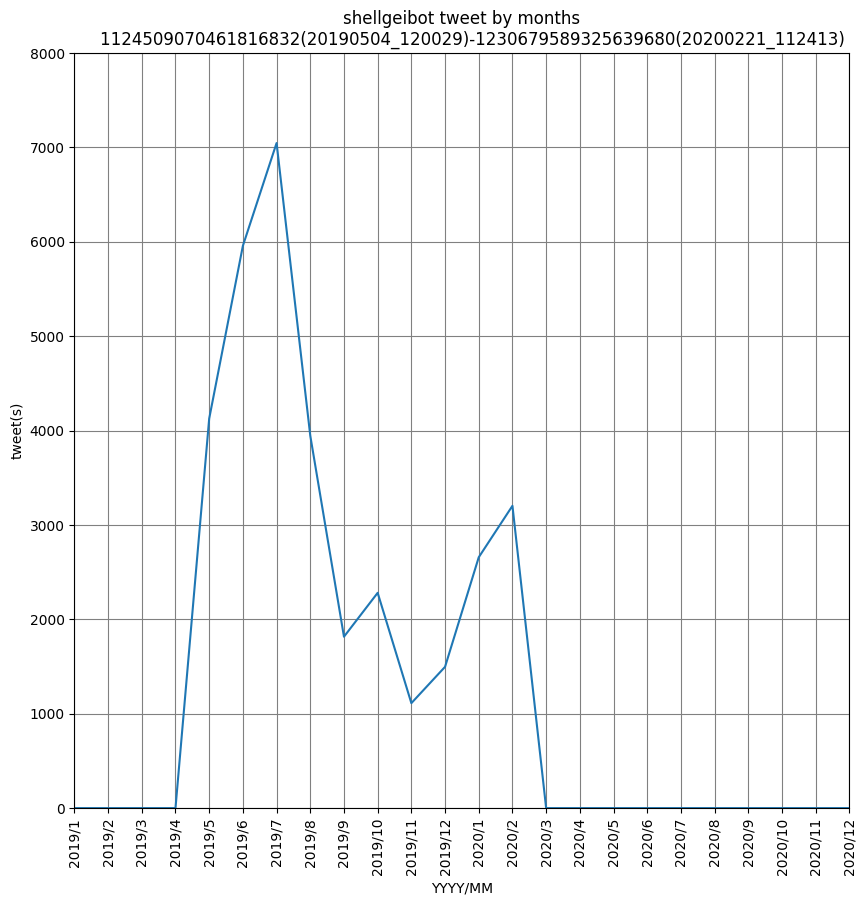

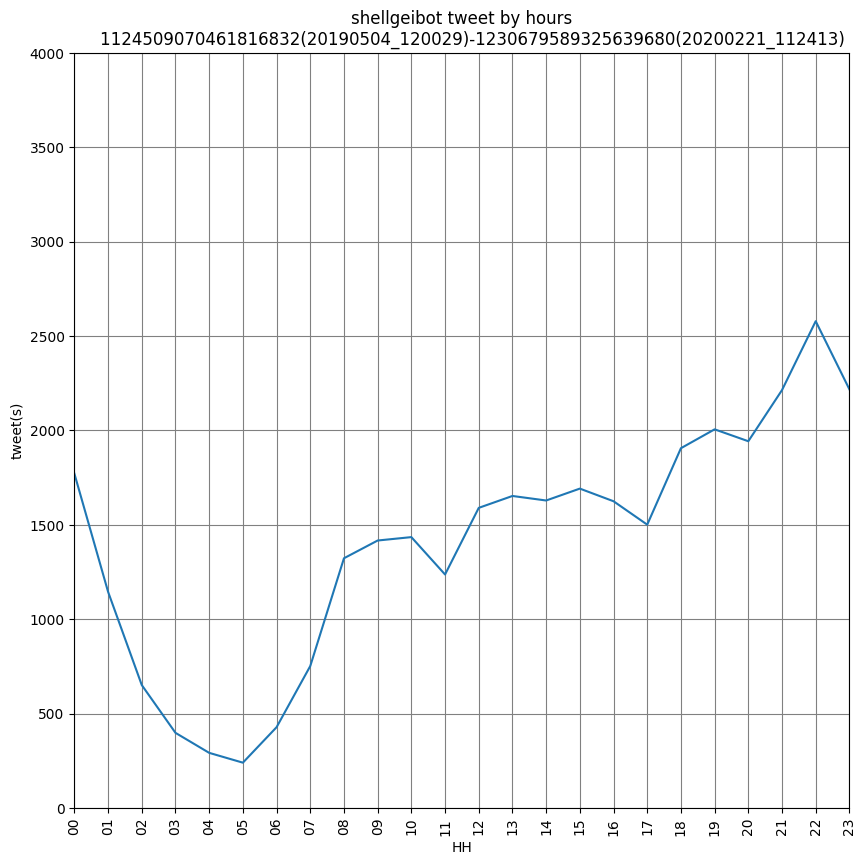

In [9]:
# make graphs
%matplotlib inline
def showgraph(name, title, xlabel, ylim):
    import numpy as np
    import matplotlib.pyplot as plt

    f=[i.split(',') for i in open(name).readlines()]
    x,y=[],[]
    for i in f:
        x.append(i[0])
        y.append(int(i[1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.xlim(0,len(x)-1)
    plt.ylim(0,ylim)
    plt.grid(color='gray')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('tweet(s)')
    plt.plot(x, y)
    plt.xticks(rotation=90)
showgraph(
    dir+"month.csv",
    """shellgeibot tweet by months
    %s""" % (file[49:][:-11]),
    "YYYY/MM",
    8000
)
showgraph(
    dir+"hour.csv",
    """shellgeibot tweet by hours
    %s""" % (file[49:][:-11]),
    "HH",
    4000
)